In [39]:
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import umap
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
import json
from collections import defaultdict

from sklearn.decomposition import PCA

In [55]:
vecs_df = pd.read_csv('gendered_word_vectors.tsv', sep='\t', index_col=0)    
vecs_df = vecs_df[~vecs_df.index.duplicated(keep='first')]
vecs_df

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
actor,0.163086,-0.106934,-0.168945,0.071289,0.048828,0.335938,-0.027466,0.059814,0.183594,-0.103516,...,0.044922,-0.029419,-0.166992,-0.203125,0.051270,0.146484,-0.197266,0.027222,-0.073730,0.068848
actress,-0.032959,-0.140625,-0.145508,-0.017578,0.086426,0.324219,-0.097168,-0.121582,0.038330,-0.088867,...,0.031982,-0.054199,-0.166016,-0.294922,0.110352,0.188477,-0.015442,0.187500,0.183594,0.005341
boar,-0.012695,-0.029419,-0.248047,0.135742,0.166016,0.298828,0.114258,0.146484,0.024902,0.197266,...,-0.159180,0.109863,-0.200195,0.156250,0.074219,-0.048340,-0.069336,-0.038818,-0.019775,0.134766
sow,0.357422,0.328125,-0.066895,0.171875,0.092285,0.185547,0.077148,0.088867,-0.132812,0.018677,...,-0.257812,0.347656,-0.173828,-0.080566,-0.069336,-0.208984,-0.099609,-0.441406,0.200195,0.273438
boy,0.235352,0.165039,0.093262,-0.128906,0.015991,0.036133,-0.116699,-0.073242,0.138672,0.011536,...,0.019043,-0.010315,-0.115234,-0.291016,-0.059570,-0.053711,-0.074219,-0.265625,-0.103027,0.135742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
handmaiden,0.212891,-0.021851,-0.237305,0.120605,-0.283203,0.486328,0.225586,-0.214844,-0.192383,0.099609,...,-0.371094,-0.088379,-0.100098,0.060791,-0.310547,-0.257812,0.259766,0.225586,0.206055,0.273438
waiter,-0.231445,-0.125000,-0.026733,0.217773,-0.224609,0.187500,-0.091797,-0.037354,0.053955,0.204102,...,0.189453,0.030640,-0.161133,0.017090,0.261719,0.324219,-0.019897,-0.199219,0.113281,0.176758
waitress,-0.148438,-0.207031,-0.213867,0.263672,-0.024658,0.281250,-0.025513,-0.091309,0.026001,0.208984,...,0.161133,0.112305,-0.335938,-0.010315,0.134766,0.253906,0.205078,-0.022461,0.230469,-0.083008
webmaster,0.154297,-0.143555,0.039795,-0.187500,-0.093750,0.204102,0.066895,-0.075195,-0.019287,-0.423828,...,0.193359,0.009460,0.175781,0.070312,-0.058105,-0.324219,0.142578,-0.226562,-0.172852,-0.042236


In [68]:
with open('male_to_female_words.json', 'r') as f:
    m_to_fs = json.load(f)    
f_to_ms = defaultdict(lambda: [])
for m, fs in m_to_fs.items():
    for f in fs:
        f_to_ms[f] = m

plot_words = list(m_to_fs.keys()) + [fs[0] for fs in m_to_fs.values()]
plot_words = [w for w in plot_words if w in vecs_df.index]

m_words = set(m_to_fs.keys())
f_words = set(f_to_ms.keys())

In [73]:
def draw_with_vectors(df, words, m_words, f_words):
    X_plot = np.array(df.loc[words])    
    TWO_COLORS = ['#0066ff', '#ff9933']
    colors = []
    for word in words:
        if word in m_words:
            colors.append(TWO_COLORS[0])
        else: 
            colors.append(TWO_COLORS[1])
    assert len(X_plot) == len(colors)
    
    figure, ax = plt.subplots(
        1, 
        1,
        figsize = (5,5)
    ) 
    ax.scatter(X_plot[:,0], X_plot[:,1], s=2, c=colors)
    
    for word in words:
        if word in m_words:
            x_m = np.array(df.loc[word])
            fs = m_to_fs[word]
            for f in fs:
                if f in words and f in f_words:
                    x_f = np.array(df.loc[f])
                    ax.arrow(
                        x_m[0], 
                        x_m[1], 
                        x_f[0]-x_m[0], 
                        x_f[1]-x_m[1], 
                        alpha=0.05, 
                        width=0.00001
                    )
    max_x = max(X_plot[:,0])
    min_x = min(X_plot[:,0])
    max_y = max(X_plot[:,1])
    min_y = min(X_plot[:,1])
    lim = (min([min_x, min_y])-0.1, max([max_x, max_y])+0.1)
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    plt.show()

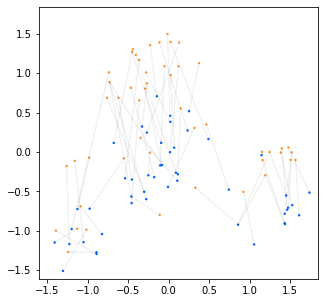

In [74]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(np.array(vecs_df))
df_pca = pd.DataFrame(data=X_pca, index=vecs_df.index)
draw_with_vectors(df_pca, plot_words, m_words, f_words)

In [83]:
import semantic_components_analysis
import importlib
importlib.reload(semantic_components_analysis)

def compute_sca(df, words, m_words, f_words):
    dir_vecs = []
    for word in words:
        if word in m_words:
            x_m = df.loc[word]
            fs = m_to_fs[word]
            for f in fs:
                if f in words and f in f_words:
                    x_f = df.loc[f]
                    print(f'{f} - {word}')
                    dir_vecs.append(x_f - x_m)
    
    dir_vecs = np.array(dir_vecs)
    print('computing SCA...')
    sca, solver_statuses =  semantic_components_analysis.SCA(dir_vecs, method='root_solver')
    assert frozenset(solver_statuses) == frozenset([True])
    return dir_vecs, sca    
dir_vecs, sca = compute_sca(vecs_df, plot_words, m_words, f_words)

actress - actor
sow - boar
girl - boy
sister - brother
doe - buck
cow - bull
businesswoman - businessman
chairwoman - chairman
mom - dad
mommy - daddy
mother - daddy
mom - daddy
duchess - duke
empress - emperor
mother - father
fisherwoman - fisherman
vixen - fox
lady - gentleman
madam - gentleman
goddess - god
grandmother - grandfather
grandma - grandpa
granddaughter - grandson
bride - groom
headmistress - headmaster
heiress - heir
heroine - hero
bitch - hound
wife - husband
queen - king
lioness - lion
woman - man
manageress - manager
miss - mister
madam - mister
murderess - murderer
niece - nephew
poetess - poet
policewoman - policeman
princess - prince
ewe - ram
hen - rooster
sculptress - sculptor
madam - sir
daughter - son
mare - stallion
stepmother - stepfather
superwoman - superman
tigress - tiger
aunt - uncle
maid - valet
waitress - waiter
webmistress - webmaster
computing SCA...
Normalizing input vectors...
done.
Solving dimension 1...
Solving dimension 2...
Solving dimension 3.

Solving dimension 296...
Solving dimension 297...
Solving dimension 298...
Solving dimension 299...


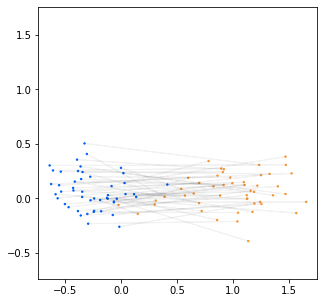

In [84]:
X_sca = np.dot(sca[[0,1]], np.array(vecs_df.loc[plot_words]).T).T
sca_df = pd.DataFrame(data=X_sca, index=plot_words)
draw_with_vectors(sca_df, plot_words, m_words, f_words)

(53, 300)
(300, 53)
(300,)


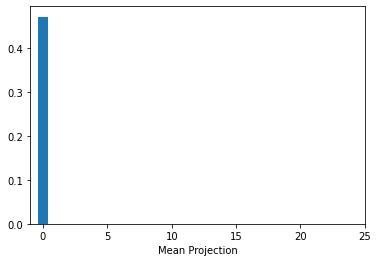

In [91]:
def plot_angle_distribution(dir_vecs, sca):
    
    # Normalize the direction vectors
    dir_vecs = np.array([e / np.linalg.norm(e) for e in dir_vecs])
    print(dir_vecs.shape)
    
    # Compute the angle distributions
    angle_distrs = []
    for beta_i, beta in enumerate(sca):
        angles = [np.dot(x, beta) for x in dir_vecs]
        angle_distrs.append(angles)
        #print(f'Component {beta_i}')
        #print(angles)
    angle_distrs = np.array(angle_distrs)
    
    print(angle_distrs.shape)
    
    # Compute the mean angle
    angle_means = np.mean(angle_distrs, axis=1)
    print(angle_means.shape)
    
    # Plot results
    plt.bar(np.arange(len(angle_means)), angle_means)
    plt.xlim((-1,25))
    plt.xlabel('Mean Projection')
    plt.show()
plot_angle_distribution(dir_vecs, sca)

(53, 300)
(2, 53)
(2,)


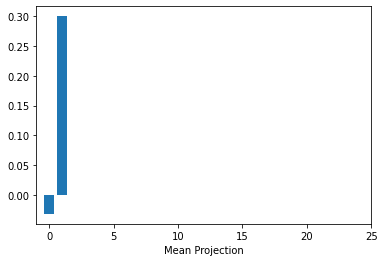

In [92]:
plot_angle_distribution(dir_vecs, pca.components_)